Epoch 0, Loss: 1.195228e-02
Epoch 20000, Loss: 2.862083e-07
Epoch 40000, Loss: 2.811936e-07
Epoch 60000, Loss: 2.795186e-07
Epoch 80000, Loss: 2.825136e-07
Epoch 100000, Loss: 2.719664e-07
Epoch 120000, Loss: 2.684762e-07
Epoch 140000, Loss: 2.690707e-07
Epoch 160000, Loss: 2.639958e-07
Epoch 180000, Loss: 2.554534e-07
Epoch 200000, Loss: 2.498741e-07
Epoch 220000, Loss: 2.471342e-07
Epoch 240000, Loss: 2.455763e-07
Epoch 260000, Loss: 2.650716e-07
Epoch 280000, Loss: 2.605875e-07
Epoch 300000, Loss: 2.571545e-07
Epoch 320000, Loss: 2.562615e-07
Epoch 340000, Loss: 2.529558e-07
Epoch 360000, Loss: 2.556998e-07
Epoch 380000, Loss: 2.499309e-07
Epoch 400000, Loss: 2.491470e-07
Epoch 420000, Loss: 2.467679e-07
Epoch 440000, Loss: 2.470131e-07
Epoch 460000, Loss: 2.417941e-07
Epoch 480000, Loss: 2.421270e-07
Epoch 500000, Loss: 2.391236e-07
Epoch 520000, Loss: 2.334557e-07
Epoch 540000, Loss: 2.397830e-07
Epoch 560000, Loss: 2.340343e-07
Epoch 580000, Loss: 2.321739e-07
Epoch 600000, Loss:

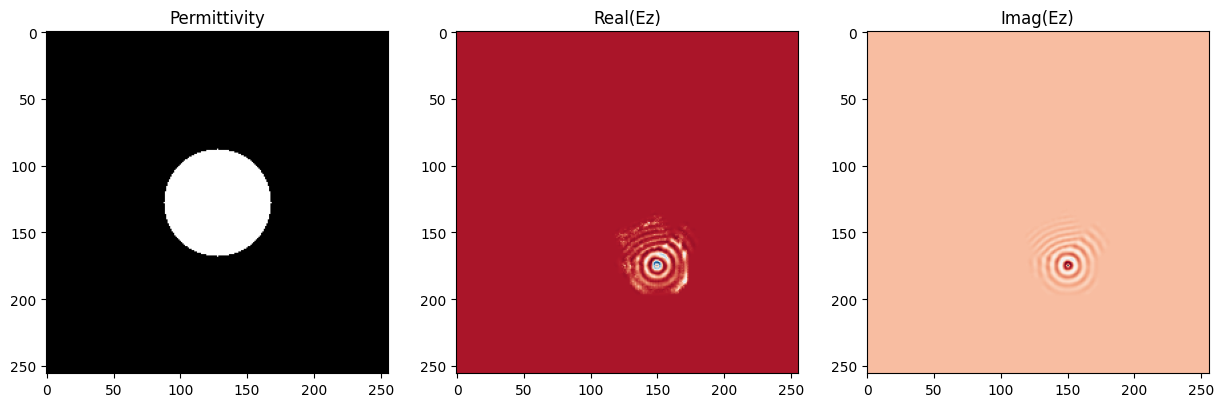

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# 1️⃣ Simple HelmNet: UNet-like model (fully included)
# =========================================================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU()
        )
    def forward(self, x):
        return self.conv(x)

class HelmNet(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=64):
        super().__init__()
        self.down1 = ConvBlock(in_channels, hidden_channels)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = ConvBlock(hidden_channels, hidden_channels*2)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(hidden_channels*2, hidden_channels*4)

        self.up2 = nn.ConvTranspose2d(hidden_channels*4, hidden_channels*2, 2, stride=2)
        self.conv2 = ConvBlock(hidden_channels*4, hidden_channels*2)
        self.up1 = nn.ConvTranspose2d(hidden_channels*2, hidden_channels, 2, stride=2)
        self.conv1 = ConvBlock(hidden_channels*2, hidden_channels)

        self.out_conv = nn.Conv2d(hidden_channels, 2, 1)  # 2 channels: real & imag

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)

        bn = self.bottleneck(p2)

        u2 = self.up2(bn)
        cat2 = torch.cat([u2, d2], dim=1)
        c2 = self.conv2(cat2)

        u1 = self.up1(c2)
        cat1 = torch.cat([u1, d1], dim=1)
        c1 = self.conv1(cat1)

        out = self.out_conv(c1)
        return out

# =========================================================
# 2️⃣ Physics loss: Helmholtz residual
# =========================================================
def helmholtz_residual(Ez_real, Ez_imag, eps, k0, Jz_real, Jz_imag, dx, dy):
    """
    Computes ||∇²Ez + k0^2 * eps * Ez + i k0 Jz||² as residual
    """
    # Laplacian of Ez_real and Ez_imag (central difference)
    def laplacian(u):
        return (
            -4 * u
            + F.pad(u, (1,1,1,1))[1:-1,1:-1,:-2,:-2] # up-left
        )

    # Better Laplacian with convolution (safer for batching)
    kernel = torch.tensor([[0, 1, 0],
                           [1, -4, 1],
                           [0, 1, 0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(Ez_real.device)
    lap_r = F.conv2d(Ez_real, kernel, padding=1) / (dx*dy)
    lap_i = F.conv2d(Ez_imag, kernel, padding=1) / (dx*dy)

    # Helmholtz residual: ∇²Ez + k0² ε Ez + i ω μ Jz
    res_r = lap_r + (k0**2) * eps * Ez_real - k0 * Jz_imag
    res_i = lap_i + (k0**2) * eps * Ez_imag + k0 * Jz_real

    return torch.mean(res_r**2 + res_i**2)

# =========================================================
# 3️⃣ Problem setup
# =========================================================
Nx, Ny = 256, 256      # grid size
dx = dy = 1.0
freq = 0.15
k0 = 2*np.pi*freq

# Permittivity map
eps = np.ones((Ny, Nx), dtype=np.float32)
cx, cy, r = Nx//2, Ny//2, 40
Y, X = np.ogrid[:Ny, :Nx]
mask = (X-cx)**2 + (Y-cy)**2 <= r**2
eps[mask] = 2.0

# Source Jz
Jz = np.zeros((Ny, Nx), dtype=np.complex64)
src_x, src_y = 150, 175
Jz[src_y, src_x] = 1.0 + 0j

# =========================================================
# 4️⃣ Torch tensors
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

eps_t = torch.tensor(eps).unsqueeze(0).unsqueeze(0).to(device)
Jz_real = torch.tensor(Jz.real).unsqueeze(0).unsqueeze(0).to(device)
Jz_imag = torch.tensor(Jz.imag).unsqueeze(0).unsqueeze(0).to(device)

# =========================================================
# 5️⃣ Model & optimizer
# =========================================================
model = HelmNet(in_channels=3, hidden_channels=32).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# =========================================================
# 6️⃣ Training loop
# =========================================================
num_epochs = 1240000
for epoch in range(num_epochs):
    opt.zero_grad()

    inp = torch.cat([eps_t, Jz_real, Jz_imag], dim=1)
    out = model(inp)

    Ez_real, Ez_imag = out[:,0:1,:,:], out[:,1:2,:,:]

    loss = helmholtz_residual(Ez_real, Ez_imag, eps_t, k0, Jz_real, Jz_imag, dx, dy)
    loss.backward()
    opt.step()

    if epoch % 20000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6e}")

# =========================================================
# 7️⃣ Visualize results
# =========================================================
Ez_real_np = Ez_real.detach().cpu().squeeze().numpy()
Ez_imag_np = Ez_imag.detach().cpu().squeeze().numpy()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(eps, cmap='gray')
axs[0].set_title("Permittivity")
axs[1].imshow(Ez_real_np, cmap='RdBu')
axs[1].set_title("Real(Ez)")
axs[2].imshow(Ez_imag_np, cmap='RdBu')
axs[2].set_title("Imag(Ez)")
plt.show()
